In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization


<font size=5>XES Analysis and Visualization Test</br>With ROTATION</font>

In [2]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1027922',lcls_run=22)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['tt/ttCorr','epics/lxt', 'enc/lasDelay' , 'ipm4/sum','tt/AMPL',r'epix_2/ROI_0_area'] 
names=['time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix']
xes.set_key_aliases(keys,names)
#xes.end_index=5000
xes.mintime=-0.9
xes.maxtime=0.9
xes.numpoints=40
xes.time_bins=np.linspace(xes.mintime,xes.maxtime,xes.numpoints)
xes.rois=[[0,50]]
xes.adu_cutoff=3.0
xes.angle=90
xes.lxt_key=None
xes.transpose=True
#xes.add_filter('xray','ipm4',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
xes.add_filter('simultaneous','time_tool_ampl',0.15)
xes.run_parser(['44-46'])
#pixels.pat

In [ ]:
start=time.time()
#xes.primary_analysis_parallel_loop(4,xes_experiment)
#xes.primary_analysis_loop(xes_experiment)
xes.primary_analysis_parallel_range(8,xes_experiment,increment=1000)
end=time.time()

Processing:   0%|          | 0/30 [00:00<?, ?Shot_Batch/s]

In [53]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='mfx',experiment_id='mfxl1027922',lcls_run=22)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
keys=['tt/ttCorr','epics/lxt', 'enc/lasDelay' , 'ipm_dg2/sum','tt/AMPL',r'epix_2/ROI_0_area'] 
names=['time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix']

#xes.add_filter('simultaneous','epix',0.15)
ret=xes.hit_find(xes_experiment,run= 47,verbose=True)
ret.load_run_keys(keys,names)
a=np.nansum(np.nansum(ret.epix,axis=1),axis=1)/ret.ipm
np.sum((a>0.02) &(a<0.5))/np.shape(ret.epix)[0]

HDF5 import of keys completed. Time: 0.00 seconds
HDF5 import of keys completed kept as hdf5 dataset. Time: 1.26 seconds
Obtained shot properties
Key: epix has been adu filtered by threshold: 3.000000
Key does not exist: Unable to open object (object 'lxt' doesn't exist)
HDF5 import of keys completed. Time: 1.15 seconds


0.37997332740609024

SyntaxError: invalid syntax (3909372002.py, line 1)

(0.0, 1000.0)

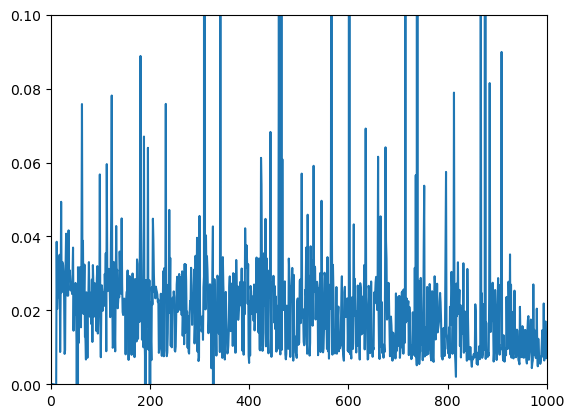

In [56]:
plt.plot(a)
plt.ylim(0,0.1)
plt.xlim(0,1000)

In [57]:
v=XSpect.XSpect_Visualization.XESVisualization()

v.combine_spectra(xes_analysis=xes,xes_key='epix_xray_not_laser_time_binned_ROI_1',xes_laser_key='epix_simultaneous_laser_time_binned_ROI_1')
v.vmin=-0.01
v.vmax=0.01
xes.analyzed_runs[0].kbeta_energy=np.linspace(6430,6370,len(xes.analyzed_runs[0].kbeta_energy))
v.plot_2d_difference_spectrum(xes)

IndexError: list index out of range

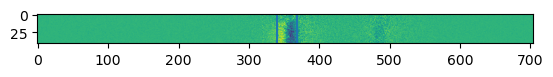

In [6]:
plt.imshow(xes.summed_laser_on_normalized-xes.summed_laser_off_normalized)
plt.axvline(340)
plt.axvline(368)


In [7]:
xes.time_bins

array([-0.9       , -0.85384615, -0.80769231, -0.76153846, -0.71538462,
       -0.66923077, -0.62307692, -0.57692308, -0.53076923, -0.48461538,
       -0.43846154, -0.39230769, -0.34615385, -0.3       , -0.25384615,
       -0.20769231, -0.16153846, -0.11538462, -0.06923077, -0.02307692,
        0.02307692,  0.06923077,  0.11538462,  0.16153846,  0.20769231,
        0.25384615,  0.3       ,  0.34615385,  0.39230769,  0.43846154,
        0.48461538,  0.53076923,  0.57692308,  0.62307692,  0.66923077,
        0.71538462,  0.76153846,  0.80769231,  0.85384615,  0.9       ])

In [8]:
diff=np.abs(xes.summed_laser_on_normalized-xes.summed_laser_off_normalized)

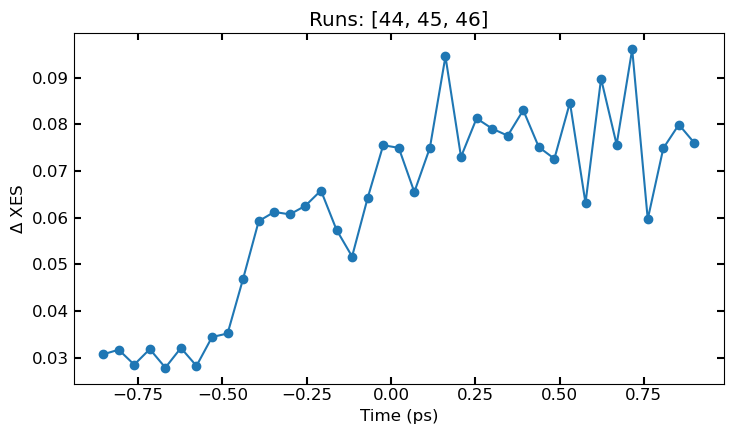

In [21]:
plt.title(f'Runs: %s' % xes.runs)
plt.plot(xes.time_bins[1:],np.nansum(diff[2:,340:368],axis=1),'o-')
plt.xlabel('Time (ps)')
plt.ylabel('$\Delta$ XES')
plt.tight_layout()

In [10]:
def error_function(x, a, b, c, d):
    return a * (1 + scipy.special.erf(b * (x - c))) + d
def gaussian(x, amplitude, center, fwhm, offset):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2)) + offset

from scipy.optimize import curve_fit
import scipy
bins_center=xes.time_bins[1:]
norm_epix=np.nansum(diff[2:,340:368],axis=1)
initial_guess = [np.max(norm_epix), 0.003, np.mean(bins_center), np.min(norm_epix)]  # Initial guess for the parameters
params, covariance = curve_fit(error_function, bins_center, norm_epix, p0=initial_guess,maxfev=99999999)

/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.62-py3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


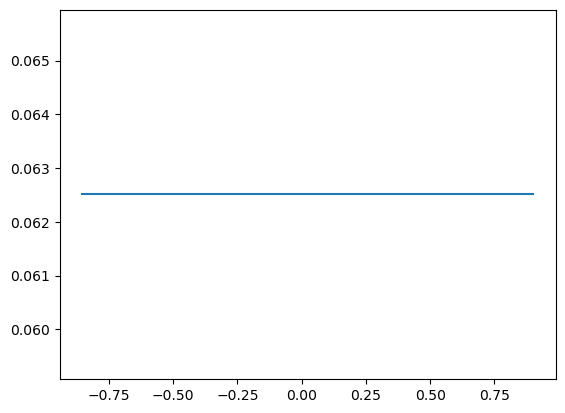

In [11]:
plt.plot(bins_center,error_function(bins_center,*params))

SVD Reconstruction performed with 8 components


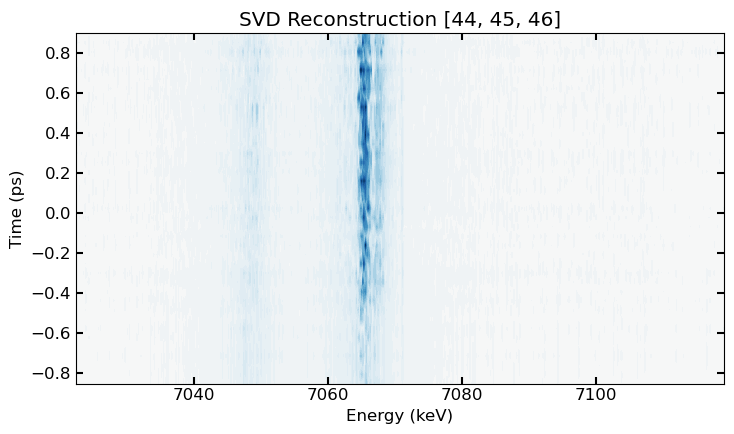

In [12]:
import XSpect.XSpect_PostProcessing
ana = XSpect.XSpect_PostProcessing.post_analysis()
nsvd = 2
diff_svd = ana.svdreconstruct(diff[2:], nsvd)
plotmax = np.max(np.abs(diff_svd))
contlevels = np.linspace(-plotmax, plotmax, 50)
plt.contourf(xes.analyzed_runs[0].kbeta_energy, xes.time_bins[1:], diff_svd, contlevels, cmap = 'RdBu')
plt.title(f'SVD Reconstruction {xes.runs}')

plt.xlabel('Energy (keV)')
plt.ylabel('Time (ps)')
plt.tight_layout()
plt.savefig(f'SVD Reconstruction {xes.runs}.jpg')

Text(0.5, 0, 'Time (ps)')

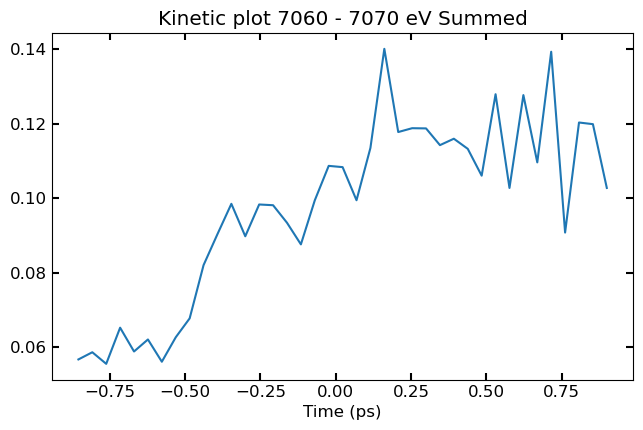

In [13]:
# en_kin_min, en_kin_max = 7.124, 7.126

# indx_min = np.argmin(np.abs(xas.ccm_bins - en_kin_min))
# indx_max = np.argmin(np.abs(xas.ccm_bins - en_kin_max))
# kintrace = np.nanmean(diff_svd[:,indx_min:indx_max], axis=1)
# plt.plot(xas.time_bins, kintrace)

low=7060
hi=7070

low_e=np.argmin(np.abs(xes.analyzed_runs[0].kbeta_energy-low))
hi_e=np.argmin(np.abs(xes.analyzed_runs[0].kbeta_energy-hi))
kintrace = np.nansum(diff_svd[:,hi_e:low_e],axis=1)
plt.plot(xes.time_bins[1:], kintrace)

plt.title(f'Kinetic plot {low} - {hi} eV Summed')
plt.xlabel('Time (ps)')

In [14]:
low_e

401

In [15]:
np.nansum(diff_svd[:,hi_e:low_e],axis=1)

array([0.05664611, 0.05857716, 0.0554647 , 0.06517753, 0.05878151,
       0.06201179, 0.05602796, 0.06259869, 0.06767701, 0.0819812 ,
       0.09031465, 0.09845625, 0.08973691, 0.09827953, 0.09807981,
       0.09337181, 0.08755923, 0.09940446, 0.10865409, 0.10831266,
       0.09941853, 0.11347417, 0.1400982 , 0.11774161, 0.11877355,
       0.11871958, 0.1142225 , 0.115947  , 0.11323133, 0.10601895,
       0.12790075, 0.10272056, 0.12767365, 0.10959512, 0.13931839,
       0.09073478, 0.12030337, 0.1198595 , 0.10272192])

In [16]:
for j,k in zip(xes.analyzed_runs[0].status_datetime,xes.analyzed_runs[0].status):
    print(j,k)

2024-06-25 06:50:37 New analysis of run 44 located in: /sdf/data/lcls/ds/mfx/mfxl1027922/hdf5/smalldata/mfxl1027922_Run0044.h5
2024-06-25 06:50:37 Key does not exist: Unable to open object (object 'lxt' doesn't exist)
2024-06-25 06:50:37 Key does not exist: Unable to open object (component not found)
2024-06-25 06:50:37 HDF5 import of keys completed. Time: 0.66 seconds
2024-06-25 06:50:37 HDF5 import of keys completed kept as hdf5 dataset. Time: 0.25 seconds
2024-06-25 06:50:37 Obtained shot properties
2024-06-25 06:50:38 Key: epix has been adu filtered by threshold: 3.000000
2024-06-25 06:50:46 Mask: simultaneous has been filtered on time_tool_ampl by minimum threshold: 0.150
Shots removed: 11
2024-06-25 06:50:46 Shots combined for detector epix on filters: simultaneous and laser into epix_simultaneous_laser
2024-06-25 06:50:46 Shots (141) separated for detector epix on filters: xray and laser into epix_xray_laser
2024-06-25 06:50:46 Generated timing bins from -0.900000 to 0.900000 in

In [17]:
np.save('XES_Time_Domain.npy',xes.difference_spectrum)